Safety score

In [ ]:
# import numpy as np
# import json 

# def calculate_safety_score(theta, t, alpha, beta, sigma, eta):
#     if t < theta:
#         return sigma * (alpha * (theta**2 - t**2) + beta * (theta - t))
#     else:
#         return eta * (alpha * (theta**2 - t**2) + beta * (theta - t))

# def calculate_path_safety_score(perfect_path, driven_path, alpha, beta, sigma, eta):
#     safety_score = 0
#     for i in range(len(perfect_path)):
#         theta = np.sqrt(perfect_path[i][0]**2 + perfect_path[i][1]**2)
#         t = np.sqrt((driven_path[i][0] - perfect_path[i][0])**2 + (driven_path[i][1] - perfect_path[i][1])**2)
#         safety_score += calculate_safety_score(theta, t, alpha, beta, sigma, eta)
#     return safety_score

# def calculate_path_safety_score_AB(perfect_path, driven_path, alpha, beta, sigma, eta, velocity, acceleration):
#     safety_score = 0
#     for i in range(len(perfect_path)):
#         theta = np.sqrt(perfect_path[i][0]**2 + perfect_path[i][1]**2)
#         t = np.sqrt((driven_path[i][0] - perfect_path[i][0])**2 + (driven_path[i][1] - perfect_path[i][1])**2)
#         alpha_i = alpha*(1+acceleration)
#         beta_i = beta*(1+velocity)
#         safety_score += calculate_safety_score(theta, t, alpha_i, beta_i, sigma, eta)
#     return safety_score


# # Load the perfect and driven path JSON files
# with open('user_input/scenario_0.json') as f:
#     perfect_path_data = json.load(f)
    
# with open('user_input/scenario_1.json') as f:
#     driven_path_data = json.load(f)

# # Extract the vehicle locations as tuples from the JSON files
# perfect_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in perfect_path_data]
# driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]

# if len(driven_path) < len(perfect_path):
#     last_item = driven_path[-1]
#     driven_path += [last_item] * (len(perfect_path) - len(driven_path))
# elif len(perfect_path) < len(driven_path):
#     last_item = perfect_path[-1]
#     perfect_path += [last_item] * (len(driven_path) - len(perfect_path))

# alpha = 1 # alpha,beta - Indicating the velocity and acceleration of an AV and surrounding vehicles 
# beta = 1
# sigma = 1 # Reward or penalty on the level of safety, when $t$ is lower or higher than $\theta$, respectively
# eta = 1
# velocity = 30 # 30 km/h  velocity of vehicles around? 
# acceleration = 0.5  # 0.5 m/s^2 acceleration of vehicles around?
# score = calculate_path_safety_score_AB(perfect_path, driven_path, alpha, beta, sigma, eta, velocity, acceleration)
# print("Safety score: " + str(score))

There are 1 files with "auto_scenario" in their name.


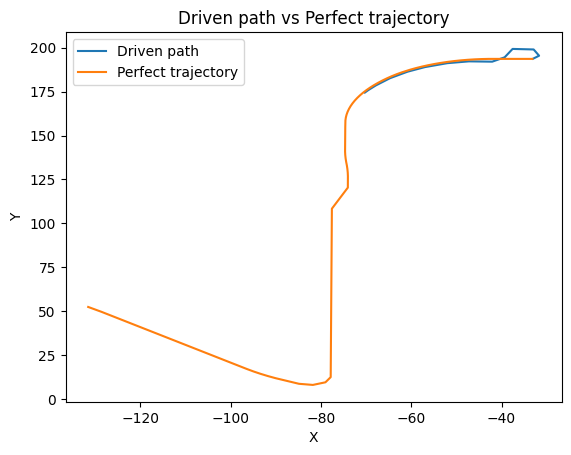

DTW: 12020.281669225713
Safety score: -5.987369392383787
Calculated score: -5.99
There are 3 generated scenarios
There are 2 files with "auto_scenario" in their name.


FileNotFoundError: [Errno 2] No such file or directory: 'user_input/route_13.json'

In [1]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import *
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import os

rated_objects = []
count = 0
for root, dirs, files in os.walk('user_input'):
    for file in files:
        if 'auto_scenario' in file:
            count += 1
            print(f'There are {count} files with "auto_scenario" in their name.')
            
            # Extract the number from the file name
            scenario_num = int(file.split('_')[-1].split('.')[0])
            
            # Open the corresponding route file
            with open(f'user_input/route_{scenario_num}.json', 'r') as f:
                trajectory = json.load(f)

            with open(f'user_input/auto_scenario_{scenario_num}.json') as f:
                driven_path_data = json.load(f)

            driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]

            # Plot the driven path
            plt.plot(*zip(*driven_path), label='Driven path')

            # Extract the X and Y coordinates from each location
            x_coords = [location['X'] for location in trajectory]
            y_coords = [location['Y'] for location in trajectory]

            # Plot the route on a graph
            plt.plot(x_coords, y_coords, label='Perfect trajectory')

            plt.title('Driven path vs Perfect trajectory')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.legend()
            plt.show()

            # Initialize lists to store data
            timestamps = []
            velocities = []
            throttles = []

            # Extract values from data
            game_time = [entry['game_time'] for entry in driven_path_data]
            velocity = [entry['vehicle_velocity']['x'] for entry in driven_path_data]
            throttle = [entry['vehicle_throttle'] for entry in driven_path_data]

            # Calculate average velocity
            avg_velocity = np.mean(velocity)
            # print(f'Average velocity: {avg_velocity:.2f} m/s')

            # # Plot velocity over time
            # plt.plot(game_time, velocity)
            # plt.xlabel('Time (s)')
            # plt.ylabel('Velocity (m/s)')
            # plt.show()



            def rate_driven_path(trajectory, driven_path, avg_velocity, num_collisions):
                # Calculate the DTW distance between the trajectory and driven path
                distance, _ = fastdtw(trajectory, driven_path, dist=euclidean)
                
                print("DTW: "+str(distance))
                # Calculate the safety score based on DTW distance and average velocity
                safety_score = max(0, 1000 - distance - avg_velocity)
                
                # Penalize for number of collisions
                safety_score -= num_collisions * (0.95**num_collisions)
                
                print("Safety score: "+str(safety_score))
                return safety_score

            perfect_trajectory_array = list(zip(x_coords, y_coords))
            driven_path_array = np.array(driven_path)

            calculated_score = rate_driven_path(perfect_trajectory_array, driven_path_array,avg_velocity,10)
            print(f'Calculated score: {calculated_score:.2f}')

            # Open the file for reading
            with open('user_input/scenarios.json', 'r') as f:
                data = json.load(f)

            print(f'There are {len(data)} generated scenarios')
            
           
            # Find the object with the desired scenario_num
            for obj in data:
                if obj['scenario_num'] == scenario_num:
                    # Add the new variable
                    obj['calculate_score'] = calculated_score  # Replace 0 with your desired value
                    rated_objects.append(obj)

# Open the file for writing
with open('user_input/rated_scenarios.json', 'w') as f:
    json.dump(rated_objects, f,indent=4)



Dynamic time warping
Dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences, which may vary in speed. 
For instance, similarities in walking could be detected using DTW, even if one person was walking faster than the other, 
or if there were accelerations and decelerations during the course of an observation. 

In [ ]:
import numpy as np
from dtw import *

# Load the perfect and driven path JSON files
with open('user_input/auto_scenario_0.json') as f:
    perfect_path_data = json.load(f)
    
with open('user_input/manual_scenario_0.json') as f:
    driven_path_data = json.load(f)

# Extract the vehicle locations as tuples from the JSON files
perfect_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in perfect_path_data]
driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]

# Convert the paths to numpy arrays
perfect_path_array = np.array(perfect_path)
driven_path_array = np.array(driven_path)

# Define a distance function to use with DTW (here, we use Euclidean distance)
def distance_func(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

# Compute the similarity value using DTW
d, _, _, _ = dtw(perfect_path, driven_path, dist=distance_func)
similarity = d

print("DTW: "+ str(similarity))

In [ ]:
from dtw import dtw
import numpy as np
import math

def euclidean_distance(point1, point2):
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2
    return math.sqrt(distance)


# Extract the vehicle locations as tuples from the JSON files
perfect_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in perfect_path_data]
driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]

# Convert the paths to numpy arrays
perfect_path_array = np.array(perfect_path)
driven_path_array = np.array(driven_path)

# Calculate the DTW distance between the two paths
distance,_,_,_= dtw(perfect_path_array, driven_path_array,dist=euclidean_distance)

# Print the DTW distance
print("DTW distance:", distance)

Paths plotted as graphs

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the perfect and driven path JSON files
with open('user_input/auto_scenario_0.json') as f:
    perfect_path_data = json.load(f)
    
with open('user_input/manual_scenario_0.json') as f:
    driven_path_data = json.load(f)

# Extract the vehicle locations as tuples from the JSON files
perfect_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in perfect_path_data]
driven_path = [(d['vehicle_location']['x'], d['vehicle_location']['y']) for d in driven_path_data]

# Plot the perfect path
plt.plot(*zip(*perfect_path))
plt.title('Auto Driven path')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot the driven path
plt.plot(*zip(*driven_path))
plt.title('Manual Driven path')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot both paths on the same graph
plt.plot([x for x, y in perfect_path], [y for x, y in perfect_path], 'b-', label='Perfect path')
plt.plot([x for x, y in driven_path], [y for x, y in driven_path], 'r-', label='Driven path')
plt.legend()
plt.show()

Plot Velocity over time

In [ ]:
import json
import matplotlib.pyplot as plt

# Load data from JSON file
with open('user_input/manual_scenario_0.json', 'r') as f:
    data = json.load(f)

# Initialize lists to store data
timestamps = []
velocities = []
throttles = []

# Extract values from data
game_time = [entry['game_time'] for entry in data]
velocity = [entry['vehicle_velocity']['x'] for entry in data]
throttle = [entry['vehicle_throttle'] for entry in data]

# Plot velocity over time
plt.plot(game_time, velocity)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()

# Plot throttle over time
plt.plot(game_time, throttle)
plt.xlabel('Time (s)')
plt.ylabel('Throttle')
plt.show()